In [1]:
import re
import logging
import traceback
import os
import sys
import commands
%matplotlib inline

In [2]:
#read in data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import scale
import nltk
from nltk import bigrams
from nltk import trigrams
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier

In [3]:
def segmenter2(ss):
    return ss.split(" ")
def convert_label(label):
    if label == 'y':
        return 1
    else:
        return 0
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier


In [5]:
# rr = classifier.predict(cntModel_test)

In [39]:
def do_compare(train_file, test_file, iter_num, classifier):
    train_h = pd.read_csv(train_file, sep="\t",header=0,names=["id","label","content","seg"], encoding="utf-8").dropna()
    test_h = pd.read_csv(test_file, sep="\t",header=0,names=["id","label","content", "seg"],  encoding="utf-8").dropna()
    test_h['predict'] = 0
    pos = train_h[train_h.label == 'y']
    neg = train_h[train_h.label == 'n']
    pos.index = range(0,len(pos))
    for i in range(iter_num):
        sub_sample = pos.iloc[np.random.choice(pos.index, neg.shape[0], replace=False)]
        train_set = pd.concat([neg, sub_sample])
        total_label = train_set.label.map(lambda x:convert_label(x))
        cv = TfidfVectorizer(analyzer=segmenter2, min_df = 2)
        cntModel = cv.fit_transform(train_set['seg'].values)
#         clf = ExtraTreesClassifier()
#         cntModel = clf.fit(cntModel, total_label).transform(cntModel)
#         scaler = StandardScaler(with_mean=False)
#         cntModel = scaler.fit_transform(cntModel)
        
        #ch2
#         from sklearn.feature_selection import SelectKBest, chi2
#         ch2 = SelectKBest(chi2, k=20000)
#         cntModel = ch2.fit_transform(cntModel, total_label)
        
        classifier.fit(cntModel, total_label)
        cntModel_test = cv.transform(test_h['seg'].values)
#         cntModel_test = clf.transform(cntModel_test)
#         cntModel_test = scaler.transform(cntModel_test)
        #ch2
#         cntModel_test = ch2.transform(cntModel_test)
        
        total_label_test = test_h.label.map(lambda x:convert_label(x))
        
        print "test acc: " + str(1 - (total_label_test  ^ classifier.predict(cntModel_test)).sum() / (cntModel_test.shape[0] + 0.0))
        test_h['predict'] = test_h['predict'] + classifier.predict(cntModel_test)
    print "bagging acc: " + str(1 - ((test_h['predict'] > iter_num/1.5) ^ total_label_test).sum()/(cntModel_test.shape[0] + 0.0))
#     print test_h[(test_h['predict'] > 0) & (test_h['predict'] < iter_num)].to_string
    return (test_h, cntModel, total_label, cv)

In [23]:
# test_h = pinyin_res[0]

In [24]:
# test_h.iloc[9457]

id                          6cc6ef8572d87098be81dd35ce895457
label                                                      n
content    在下跌浪时，找支撑是件吃力不讨好的事，下跌的速度比上涨的速度大3倍，因为恐惧比乐观还可怕。来...
seg        在 zai4 下跌 xia4die1 浪 lang4 时 shi2 ， none5 找 zh...
predict                                                    0
Name: 9457, dtype: object

In [25]:
# pinyin_res[1]

<86828x73112 sparse matrix of type '<type 'numpy.float64'>'
	with 3804522 stored elements in Compressed Sparse Row format>

In [21]:
# cv = pinyin_res[3]

In [13]:
# features = cv.get_feature_names()

In [14]:
# features = pd.Series(features)

In [30]:
res = test_h[test_h['predict']//3 != test_h.label.map(lambda x:convert_label(x))]

In [31]:
res.to_csv("wrong.data",sep="\t",encoding="utf-8")

## feature process:
- origin: 75%
- pinyin: 80%
- remove Number head : 83%
- regularize han number: 83.2%
- qq bi tr gram: 84.4%
- NR: nearly 85%
- negtive weight: 88%

In [36]:
pinyin_res = do_compare("../corpus/seg.data.pinyin", "../corpus/seg.test.data.pinyin", 3, LinearSVC(C = 0.01, class_weight={0:5, 1:1}))

test acc: 0.877553053701
test acc: 0.880143469164
test acc: 0.88432798645
bagging acc: 0.879645312344


In [37]:
classifier = LinearSVC(C = 0.01, class_weight={0:5, 1:1})

In [ ]:
# normal_res = do_compare("../corpus/seg.data", "../corpus/seg.test.data", 10, LinearSVC(C = 0.01))

In [75]:
# rf_classifier = RandomForestClassifier(n_estimators=1000)
# normal_res =  do_compare("../corpus/seg.data", "../corpus/seg.test.data", 10, rf_classifier)

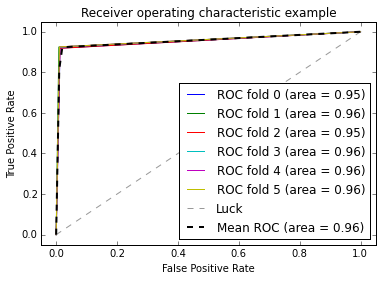

In [38]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold

def correctForm(x):
    if x >= 1: return 1
    else: return 0
def crossValidationWithROC(X, y, n_folds):
    ###############################################################################
    # Classification and ROC analysis
    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(y, n_folds,shuffle=True)
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for i, (train, test) in enumerate(cv):
        probas_ = classifier.fit(X[train], y[train].map(lambda x: correctForm(x))).predict(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test].map(lambda x: correctForm(x)), probas_)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
pinyin_res[2].index=range(0,len(pinyin_res[2]))
crossValidationWithROC(pinyin_res[1], pinyin_res[2], 6)

In [28]:
# def getWord(aa):
#     if aa.flag == u'm':
#         return aa.word[0] + 'NUM' + str(len(aa.word))
#     else:
#         return aa.word
# dict_ = pd.read_csv("lungutang.guanggao.words", "\t")
# dict_.label = 3
# dict_.to_csv("user_dict.data", sep=" ", index=False, header=False)
# #jieba segmenter
# import jieba
# import jieba.posseg as pseg
# jieba.load_userdict("user_dict.data")
# jieba.enable_parallel(4)
# def segmenter(line):
#     words = pseg.cut(line)
#     return ' '.join(map(getWord, list(words)))
#feature selection
# from sklearn.feature_selection import SelectKBest, chi2
# ch2 = SelectKBest(chi2, k=10000)
# cntModel = ch2.fit_transform(cntModel, total_label)
# bb = ch2.get_support()
# features =cv.get_feature_names()
# features= np.array(features)
# topFeature = np.array(features)[bb == True]
# pd.DataFrame(topFeature).to_csv("feature.data", encoding="utf-8")
# from sklearn.linear_model import SGDClassifier
#logistic
# classifier = SGDClassifier(loss="log", penalty="l2",class_weight={0:10,1:1}, average=True, n_iter = 100, alpha=0.001)
# clf.fit(cntModel, total_label)

# one gram
## initial: default n_iter=100
stable
## alpha=0.001
because high dimension: deal with overfitting

## hash vs count vs tfidf
count
- lr l2 0.48550724637681164 0.67
- lr l1 
- hinge l1
- hinge l2

tfidf
- lr l2 0.66304347826086962 0.66
- lr l1 0.44202898550724634 0.64
- hinge l1 0.49637681159420288 0.63
- hinge l2 0.69565217391304346 0.64
- svc 0.52173913043478259 0.62
- svc with ch2 top 200 0.59 0.63

## after change : n_iter = 100, alpha=0.1
lr : 0.97826086956521741 overall:0.92960971480852683

# bigram top 1000
- lr l2 0.49 0.52
- svc l2 0.58 0.64
# bigram top 10000
- lr 0.57 0.59
# bigram top 100000
- lr 0.60 0.62
- svc 0.61 0.64 

# pos sub sample + jieba seg + user difine user dict

- svc : auc: 94%
